In [ ]:
import numpy as np
from tigramite.independence_tests import OracleCI
from tigramite import plotting as tp

### Links of the Causal Graph

Links can be initialized as a dictionary with a (key, value) pair for each variable $i$:

$\{i:[(j,0),(k,0)]\}$

where $i$ has $j,k$ as parents at lag 0.
In this excercise, all causal links are assumed to be at lag 0, i.e., we work with non-time-series data.

In [ ]:
#For an unshielded collider links should look as follows:

links = {0: [(1, 0), (2, 0)], 1: [], 2: []}

### Visualizing the Graph

Use the functionality of OracleCI to generate a graph corresponding to the links.

Note that the graph is mirror-symmetric around the diagonal, i.e., if $i$ is a parent of $j$ $\Rightarrow$ $j$ is a child of $i$

In [ ]:
oracle = OracleCI(links=links)

graph = oracle.graph

print(graph[:, :, 0])

In [ ]:
tp.plot_graph(graph=graph)

### Testing for Conditional Independence

Recall that the null hypothesis is (conditional) independence, so:

p-value == 1 $\Rightarrow$ independence

p-value == 0 $\Rightarrow$ dependence

In [ ]:
# Test whether 1 and 2 are independent given Z = empty set versus Z = 0.
_, pval_1 = oracle.run_test(X=[(1, 0)], Y=[(2, 0)], Z=[])
_, pval_2 = oracle.run_test(X=[(1, 0)], Y=[(2, 0)], Z=[(0, 0)])
pval_1, pval_2

### Write a class to run the PC algorithm
with arguments
1. total number of variables and

2. oracle object

In [43]:
import networkx as nx
import itertools


class PC:
    n_var: int
    oracle: OracleCI

    def __init__(self, n_var: int, oracle: OracleCI):
        self.n_var = n_var
        self.oracle = oracle

    def run(self):
        # No self-loops: Remove diagonal
        adj = (np.ones((self.n_var, self.n_var)) - np.identity(self.n_var)).astype(np.int8)
        sepsets = [[[] for i in range(self.n_var)] for j in range(self.n_var)]
        p = 0

        # Step 1: Obtain skeleton
        # While there exists an ordered pair (X, Y) where | adj(G, Y) \ X | >= p
        # adj.sum(1) - 1 : Sum all the adjacencies of Y minus any X
        while np.any(adj.sum(1) - 1 >= p):
            # i = index of Y
            for i in range(self.n_var):
                # For all S in adj(G, Y) \ X where |S| = p do
                if adj[i].sum() - 1 < p:
                    continue

                # Get all S in adj(G, Y) \ X of length P
                # j = index of X
                for j in range(self.n_var):
                    if adj[i][j] == 0:
                        continue

                    # Get the set of adjacencies of Y without X
                    remaining_adj = np.copy(adj[i])
                    remaining_adj[j] = 0
                    remaining_adj_ind = np.argwhere(remaining_adj > 0).flatten()
                    # Test all subsets of cardinality p
                    for S in itertools.combinations(remaining_adj_ind, p):
                        _, pval = self.oracle.run_test(X=[(j, 0)], Y=[(i, 0)], Z=[(s, 0) for s in S])
                        if pval == 1:
                            adj[i, j] = adj[j, i] = 0
                            sepsets[i][j] = sepsets[j][i] = list(S)
                            break
            p += 1

        # Step 2: Orient all unshielded triplets
        cpdag = adj.copy()
        for y in range(0, self.n_var):
            if cpdag[y].sum() < 2:
                continue

            xz_edges = np.argwhere(cpdag[y] > 0).flatten()
            for S in itertools.combinations(xz_edges, 2):
                (x, z) = S
                if adj[x, z] == 1:
                    # Triplet is shielded
                    continue

                if y not in sepsets[x][z]:
                    # Then y is a collider and we remove its outgoing edges to x and z
                    cpdag[y, x] = cpdag[y, z] = 0

        # Step 3: Apply orientation rules
        self.apply_rule1(cpdag)

        # We apply rule 3 before rule 2, because applying rule 2 once destroys
        # the structure required for rule 3
        self.apply_rule3(cpdag)
        self.apply_rule2(cpdag)

        return cpdag, self._cpdag_to_links(cpdag)

    """
    Rule 1:

    X -> Y - Z becomes X -> Y -> Z
    The alternative would be a new unshielded triplet contradicting the end of step 2
    """
    def apply_rule1(self, cpdag):
        # In cpdag adj matrix terms:
        # 1. If there is at least one edge pointing to Y
        # 2. Then orient all other
        for y in range(0, self.n_var):
            if cpdag[y].sum() < 1:
                continue

            # all j pointing to y
            inbound = np.argwhere(cpdag[:, y] == 1).flatten()

            has_outbound = cpdag[y, inbound] == 1
            unoriented = inbound[has_outbound]
            only_inbound = inbound[~has_outbound]
            if len(only_inbound) > 0:
                # Orient all edges, i.e. remove inbound cpdag entries
                cpdag[unoriented, y] = 0

    """
    Rule 2:

     X────┐
     │    │
     ▼    │
     Y───►Z  -> orient Z -> X to prevent a cycle
    """
    def apply_rule2(self, cpdag):
        # In cpdag matrix terms:
        # All the outbound only vertices must not point to the inbound only vertices
        for y in range(0, self.n_var):
            if cpdag[y].sum() < 1:
                continue

                # all j pointing to y
            inbound = np.argwhere(cpdag[:, y] == 1).flatten()
            only_inbound = inbound[cpdag[y, inbound] == 0]

            outbound = np.argwhere(cpdag[y, :] == 1).flatten()
            only_outbound = outbound[cpdag[outbound, y] == 0]

            # Set all edges pointing only_outbound -> only_inbound = 0
            cpdag[only_outbound, only_inbound] = 0

    """
    Rule 3:
    ┌──X──┐
    │  │  │
    Y  │  Z
    │  │  │
    └─►W◄─┘  -> Orient X -> W

    Why? Applying rule 2 (x2) would lead to a new unshielded collider X, Z, W
    This would contradict the end of step 2
    """
    def apply_rule3(self, cpdag):
        for x in range(0, self.n_var):
            if cpdag[x].sum() < 1:
                continue

            outbound_ind = np.argwhere(cpdag[x] > 0).flatten()
            for triplet in itertools.combinations(outbound_ind, 3):
                triplet_ind = np.array(triplet)
                # Skip if any of the three are oriented
                if cpdag[triplet_ind, x].sum() != 3:
                    continue

                # Find W and orient X -> W
                for edge in triplet:
                    other_edges = triplet_ind[triplet_ind != edge]

                    # Do the other two edges point to edge?
                    if cpdag[other_edges, edge].sum() == 2 and cpdag[edge, other_edges].sum() == 0:
                        # Orient X -> W (by removing W -> X) and break
                        cpdag[edge, x] = 0
                        break

    def _cpdag_to_links(self, cpdag):
        links = {n: [] for n in range(self.n_var)}
        for i in range(0, self.n_var):
            for j in range(0, self.n_var):
                if cpdag[i, j] != 0:
                    links[j] += [(i, 0)]
        return links


In [ ]:
# Rule 1 test
a = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 0]])
PC(3, None).apply_rule1(a)
print(a)
assert a[2, 1] == 0, "The Y - Z edge should have been oriented Y -> Z"

In [ ]:
# Rule 2 test
a = np.array([
    [0, 1, 1],
    [0, 0, 1],
    [1, 0, 0]])
PC(3, None).apply_rule2(a)
print(a)
assert a[2, 0] == 0, "The Z - X edge should have been oriented X -> Z"

In [42]:
# Rule 3 test
a = np.array([
    [0, 1, 1, 1],
    [1, 0, 0, 1],
    [1, 0, 0, 1],
    [1, 0, 0, 0]])
PC(4, None).apply_rule3(a)
print(a)
assert a[3, 0] == 0, "The X - W edge should have been oriented X -> W"

edge 1 triplet [1 2 3] cond [False  True  True] 
edge 2 triplet [1 2 3] cond [ True False  True] 
edge 3 triplet [1 2 3] cond [ True  True False] 
[[0 1 1 1]
 [1 0 0 1]
 [1 0 0 1]
 [0 0 0 0]]


### Test your PC algorithm on this causal graph (aka Y-structure):
links =  {0: [], 1: [], 2: [(0,0), (1,0)], 3: [(2,0)]}

[[0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]
{0: [], 1: [], 2: [(0, 0), (1, 0)], 3: [(2, 0)]}


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

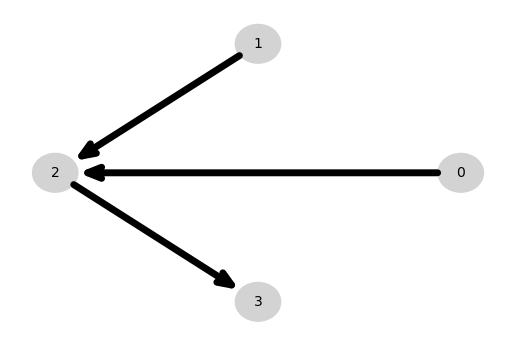

In [44]:
links = {0: [], 1: [], 2: [(0, 0), (1, 0)], 3: [(2, 0)]}
pc = PC(4, OracleCI(links=links))
cpdag, links = pc.run()
print(cpdag)
print(links)
tp.plot_graph(graph=OracleCI(links=links).graph)
